# Creating the grid, mask, and topography

## The Grid object

In [1]:
from roms_tools import Grid

We can create a ROMS grid, mask, and topography by creating an instance of the `Grid` class.

In [2]:
%%time

grid = Grid(
    nx=100,  # number of points in the x-direction (not including 2 boundary cells on either end)
    ny=100,  # number of points in the y-direction (not including 2 boundary cells on either end)
    size_x=1800,  # size of the domain in the x-direction (in km)
    size_y=2400,  # size of the domain in the y-direction (in km)
    center_lon=-10,  # longitude of the center of the domain
    center_lat=61,  # latitude of the center of the domain
    rot=20,  # rotation of the grid's x-direction from lines of constant longitude, with positive values being a counter-clockwise rotation
)

CPU times: user 2.98 s, sys: 726 ms, total: 3.71 s
Wall time: 4.8 s


To visualize the grid we have just created, we can use the `.plot` method.

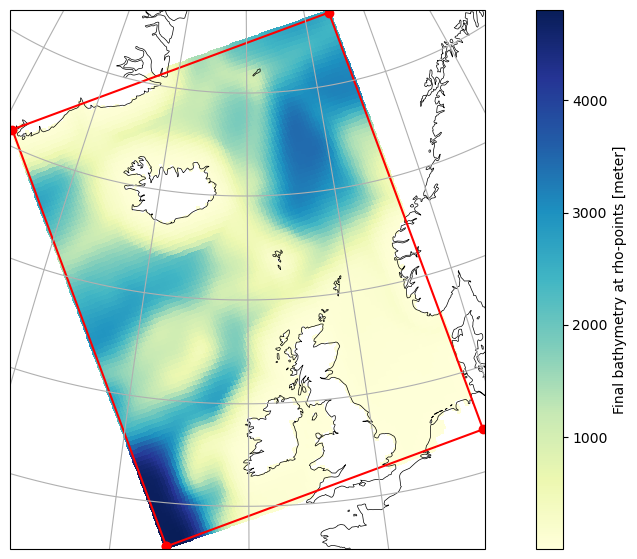

In [3]:
grid.plot(bathymetry=True)

To see the values of the grid variables, we can examine the `xarray.Dataset` object returned by the `.ds` property

In [4]:
grid.ds

<xarray.Dataset> Size: 26MB
Dimensions:              (eta_rho: 102, xi_rho: 102, xi_u: 101, eta_v: 101,
                          eta_coarse: 52, xi_coarse: 52, s_rho: 100, s_w: 101)
Coordinates: (12/14)
    lat_rho              (eta_rho, xi_rho) float64 83kB 47.84 47.91 ... 73.53
    lon_rho              (eta_rho, xi_rho) float64 83kB 344.0 344.3 ... 4.207
    lat_u                (eta_rho, xi_u) float64 82kB 47.87 47.94 ... 73.5 73.52
    lon_u                (eta_rho, xi_u) float64 82kB 344.2 344.4 ... 3.925
    lat_v                (eta_v, xi_rho) float64 82kB 47.94 48.0 ... 73.4 73.42
    lon_v                (eta_v, xi_rho) float64 82kB 344.0 344.2 ... 4.246
    ...                   ...
    layer_depth_rho      (eta_rho, xi_rho, s_rho) float32 4MB 4.733e+03 ... 1...
    layer_depth_u        (eta_rho, xi_u, s_rho) float32 4MB 4.733e+03 ... 1.363
    layer_depth_v        (eta_v, xi_rho, s_rho) float32 4MB 4.733e+03 ... 1.363
    interface_depth_rho  (eta_rho, xi_rho, s_w) float32 4MB 4.771e+03 ... -0.0
    interface_depth_u    (eta_rho, xi_u, s_w) float32 4MB 4.771e+03 ... -0.0
    interface_depth_v    (eta_v, xi_rho, s_w) float32 4MB 4.771e+03 ... -0.0
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v, eta_coarse,
                                xi_coarse, s_rho, s_w
Data variables: (12/13)
    angle                (eta_rho, xi_rho) float64 83kB 0.4177 0.4177 ... 0.1146
    f                    (eta_rho, xi_rho) float64 83kB 0.0001078 ... 0.0001395
    pm                   (eta_rho, xi_rho) float64 83kB 4.209e-05 ... 4.209e-05
    pn                   (eta_rho, xi_rho) float64 83kB 5.592e-05 ... 5.592e-05
    spherical            |S1 1B b'T'
    mask_rho             (eta_rho, xi_rho) int32 42kB 1 1 1 1 1 1 ... 1 1 1 1 1
    ...                   ...
    mask_v               (eta_v, xi_rho) int32 41kB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    h                    (eta_rho, xi_rho) float64 83kB 4.771e+03 ... 2.524e+03
    angle_coarse         (eta_coarse, xi_coarse) float64 22kB 0.4166 ... 0.1151
    mask_coarse          (eta_coarse, xi_coarse) int32 11kB 1 1 1 1 ... 1 1 1 1
    sc_r                 (s_rho) float32 400B -0.995 -0.985 ... -0.015 -0.005
    Cs_r                 (s_rho) float32 400B -0.992 -0.9753 ... -9.874e-06
Attributes:
    title:               ROMS grid created by ROMS-Tools
    roms_tools_version:  0.1.dev73+dirty
    size_x:              1800
    size_y:              2400
    center_lon:          -10
    center_lat:          61
    rot:                 20
    topography_source:   ETOPO5
    hmin:                5.0
    theta_s:             5.0
    theta_b:             2.0
    hc:                  300.0

## Saving as NetCDF or YAML file

Once we are happy with our grid, we can save it as a netCDF file via the `.save` method:

In [5]:
filepath = "/glade/derecho/scratch/noraloose/grids/my_roms_grid.nc"

In [6]:
grid.save(filepath)

We can also export the grid parameters to a YAML file.

In [7]:
yaml_filepath = "/glade/derecho/scratch/noraloose/grids/my_roms_grid.yaml"

In [8]:
grid.to_yaml(yaml_filepath)

This is the contents of the written YAML file.

In [9]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 0.1.dev73+dirty
---
Grid:
  N: 100
  center_lat: 61
  center_lon: -10
  hc: 300.0
  hmin: 5.0
  nx: 100
  ny: 100
  rot: 20
  size_x: 1800
  size_y: 2400
  theta_b: 2.0
  theta_s: 5.0
  topography_source: ETOPO5



The YAML file can help us to recreate the exact same grid object at a later point in time.

## Creating a grid from an existing NetCDF or YAML file

We can also create a grid from an existing file.

In [10]:
filepath = "/glade/derecho/scratch/noraloose/grids/my_roms_grid.nc"

In [11]:
the_same_grid = Grid.from_file(filepath)

In [12]:
the_same_grid.ds

<xarray.Dataset> Size: 26MB
Dimensions:              (eta_rho: 102, xi_rho: 102, xi_u: 101, eta_v: 101,
                          eta_coarse: 52, xi_coarse: 52, s_rho: 100, s_w: 101)
Coordinates: (12/14)
    lat_rho              (eta_rho, xi_rho) float64 83kB ...
    lon_rho              (eta_rho, xi_rho) float64 83kB ...
    lat_u                (eta_rho, xi_u) float64 82kB ...
    lon_u                (eta_rho, xi_u) float64 82kB ...
    lat_v                (eta_v, xi_rho) float64 82kB ...
    lon_v                (eta_v, xi_rho) float64 82kB ...
    ...                   ...
    layer_depth_rho      (eta_rho, xi_rho, s_rho) float32 4MB ...
    layer_depth_u        (eta_rho, xi_u, s_rho) float32 4MB ...
    layer_depth_v        (eta_v, xi_rho, s_rho) float32 4MB ...
    interface_depth_rho  (eta_rho, xi_rho, s_w) float32 4MB ...
    interface_depth_u    (eta_rho, xi_u, s_w) float32 4MB ...
    interface_depth_v    (eta_v, xi_rho, s_w) float32 4MB ...
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v, eta_coarse,
                                xi_coarse, s_rho, s_w
Data variables: (12/13)
    angle                (eta_rho, xi_rho) float64 83kB ...
    f                    (eta_rho, xi_rho) float64 83kB ...
    pm                   (eta_rho, xi_rho) float64 83kB ...
    pn                   (eta_rho, xi_rho) float64 83kB ...
    spherical            |S1 1B ...
    mask_rho             (eta_rho, xi_rho) int32 42kB ...
    ...                   ...
    mask_v               (eta_v, xi_rho) int32 41kB ...
    h                    (eta_rho, xi_rho) float64 83kB ...
    angle_coarse         (eta_coarse, xi_coarse) float64 22kB ...
    mask_coarse          (eta_coarse, xi_coarse) int32 11kB ...
    sc_r                 (s_rho) float32 400B ...
    Cs_r                 (s_rho) float32 400B ...
Attributes:
    title:               ROMS grid created by ROMS-Tools
    roms_tools_version:  0.1.dev73+dirty
    size_x:              1800
    size_y:              2400
    center_lon:          -10
    center_lat:          61
    rot:                 20
    topography_source:   ETOPO5
    hmin:                5.0
    theta_s:             5.0
    theta_b:             2.0
    hc:                  300.0

Alternatively, we can create a grid from an existing YAML file.

In [13]:
yaml_filepath = "/glade/derecho/scratch/noraloose/grids/my_roms_grid.yaml"

In [14]:
%time yet_the_same_grid = Grid.from_yaml(yaml_filepath)

CPU times: user 2.85 s, sys: 699 ms, total: 3.55 s
Wall time: 7.36 s


## Changing the minimal ocean depth `hmin`

We need to make sure that tidal excursion does not exceed the water depth at runtime. Since ROMS currently has no wetting / drying, the model will crash if the water level goes negative. The minimum ocean depth `hmin` should therefore be set to a stricly positive value. The default for `hmin` is 5 meters. In the above example, we did not specify the (optional) `hmin` parameter, so it was set to the default value.

In [15]:
grid.hmin

5.0

Let's confirm that the minimum ocean depth is indeed at least 5 meters.

In [16]:
grid.ds["h"].min()

<xarray.DataArray 'h' ()> Size: 8B
array(5.)

We can define a grid with a different `hmin`.

In [17]:
%%time

grid_with_larger_hmin = Grid(
    nx=100,
    ny=100,
    size_x=1800,
    size_y=2400,
    center_lon=-10,
    center_lat=61,
    rot=20,
    hmin=10.0,  # Minimum ocean depth in meters (default: 5.0)
)

CPU times: user 2.45 s, sys: 710 ms, total: 3.16 s
Wall time: 6.65 s


In [18]:
grid_with_larger_hmin.ds["h"].min()

<xarray.DataArray 'h' ()> Size: 8B
array(10.)

Alternatively, we could have just updated the topography of our original grid via the `.add_topography_and_mask` method.

In [19]:
%time grid.update_topography_and_mask(hmin=10.0)

CPU times: user 1.51 s, sys: 45.6 ms, total: 1.55 s
Wall time: 4.03 s


In [20]:
grid.hmin

10.0

In [21]:
grid.ds["h"].min()

<xarray.DataArray 'h' ()> Size: 8B
array(10.)

## Changing the vertical coordinate system

ROMS uses a terrain-following vertical coordinate system. The vertical coordinate system is important for `ROMS-Tools` while creating input fields that have a depth dimension, such as the initial conditions or the boundary forcing.

`ROMS-Tools` creates the vertical coordinate system as part of the grid generation, according to
<cite data-cite="shchepetkin_correction_2009">(Shchepetkin and McWilliams, 2009)</cite>, see also Figure 2 in
<cite data-cite="lemarie_are_2012">(Lemarié et al., 2012)</cite>.
For this, it needs four additional parameters:
* `N`: the number of vertical levels (default: 100)
* `theta_s`: the surface control parameter (default: 5.0)
* `theta_b`: the bottom control parameter (default: 2.0)
* `hc`: the critical depth in meters (default: 300.0)

In the above example, we did not specify any of these (optional) four parameters, so they were set to the default values.

In [22]:
print(f"N: {grid.N}, theta_s: {grid.theta_s}, theta_b: {grid.theta_b}, hc: {grid.hc}")

N: 100, theta_s: 5.0, theta_b: 2.0, hc: 300.0


We can plot the vertical coordinate system from different angles via the `.plot_vertical_coordinate` method. Let's start by looking at the depth of different layers and interfaces.

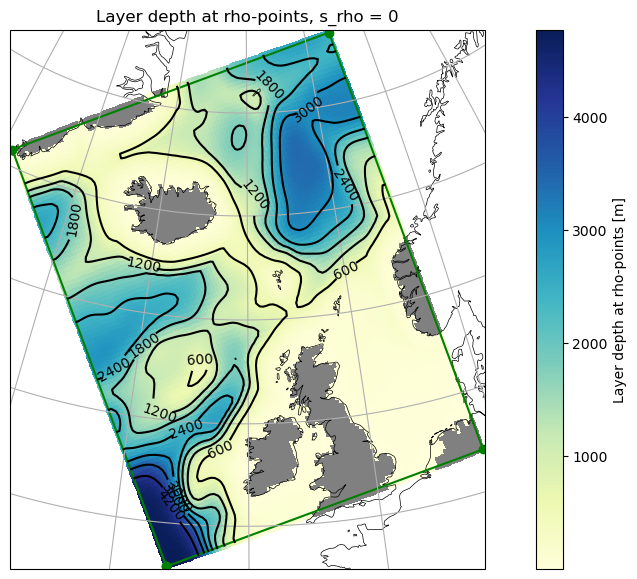

In [23]:
grid.plot_vertical_coordinate(
    "layer_depth_rho", s=0
)  # depth of the lowermost layer at rho-points

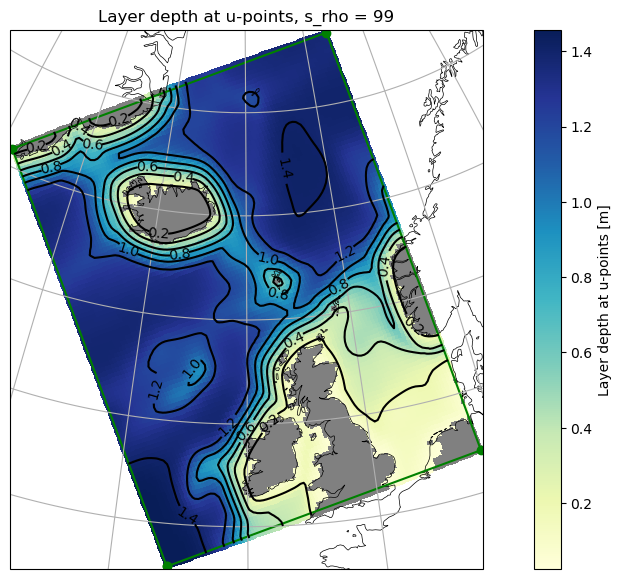

In [24]:
grid.plot_vertical_coordinate(
    "layer_depth_u", s=-1
)  # depth of the uppermost layer at u-points

In contrast, the depth of the uppermost interface (at `rho`-, `u`- and `v`-points) is equal to zero because the creation of the `Grid` object has no information about the sea surface height and assumes that it is zero everywhere. 

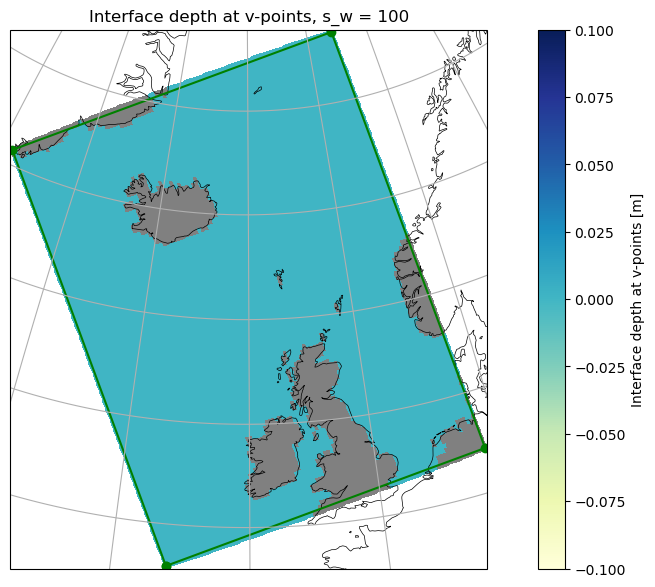

In [25]:
grid.plot_vertical_coordinate(
    "interface_depth_v", s=-1
)  # depth of the uppermost interface at v-points

<div class="alert alert-info">

Note

The same assumption of zero sea surface height also goes into the creation of the initial conditions and the boundary forcing, for which we will use the `Grid` object from this notebook. Note, however, that during runtime ROMS will dynamically adjust the vertical coordinate to account for varying sea surface height.

</div>

We are now interested in a vertical view of our layers. We can look at a transect by slicing through the `eta` or `xi` dimensions.

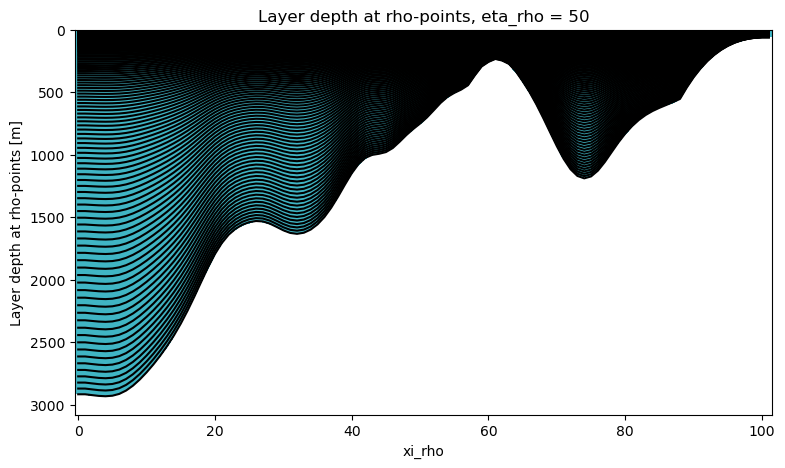

In [26]:
grid.plot_vertical_coordinate("layer_depth_rho", eta=50)

The upper ocean layers are so densely packed that the lines converge and become indistinguishable. 

If you want to update the vertical coordinate system but leaving the remaining grid parameters unchanged, you can do so with the `.update_vertical_coordinate` method.

In [27]:
grid.update_vertical_coordinate(N=20, theta_s=5.0, theta_b=2.0, hc=300.0)

In the cell above, we regenerated the vertical coordinate system but this time only with 20 layers.

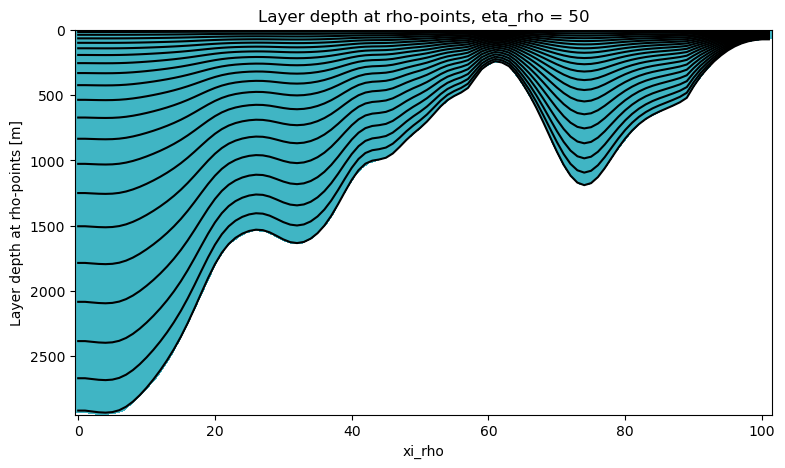

In [28]:
grid.plot_vertical_coordinate("layer_depth_rho", eta=50)

### Vertical coordinate system parameters
To investigate the vertical coordinate system parameters, we start with a control grid.

In [29]:
fixed_grid_parameters = {
    "nx": 100,
    "ny": 100,
    "size_x": 1800,
    "size_y": 2400,
    "center_lon": -21,
    "center_lat": 61,
    "rot": 20,
    "N": 20,
}

In [30]:
control_grid = Grid(
    **fixed_grid_parameters,
    theta_s=5.0,
    theta_b=2.0,
    hc=300.0,
)

In [31]:
control_grid

Grid(nx=100, ny=100, size_x=1800, size_y=2400, center_lon=-21, center_lat=61, rot=20, N=20, theta_s=5.0, theta_b=2.0, hc=300.0, topography_source='ETOPO5', hmin=5.0, straddle=False)

We will now change the vertical coordinate system parameters `theta_s`, `theta_b`, and `hc`, and see what effect this has.

#### Critical depth `hc`

The critical depth `hc` sets the transition between flat $z$-levels in the upper ocean and terrain-following sigma-levels below. Usually we want to choose `hc` to be comparable with the expected depth of the pycnocline. That being said, let's experiment with the `hc` parameter. 

In [32]:
grid_with_large_critical_depth = Grid(
    **fixed_grid_parameters,
    theta_s=control_grid.theta_s,
    theta_b=control_grid.theta_b,
    hc=1000.0,
)

grid_with_small_critical_depth = Grid(
    **fixed_grid_parameters,
    theta_s=control_grid.theta_s,
    theta_b=control_grid.theta_b,
    hc=50.0,
)

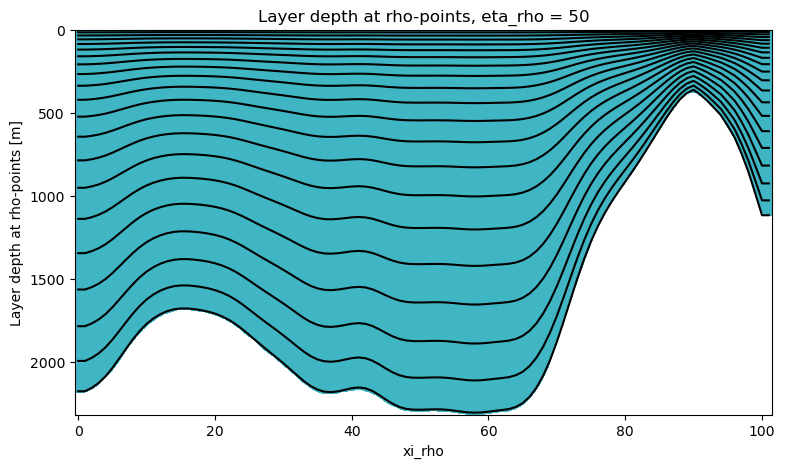

In [33]:
control_grid.plot_vertical_coordinate("layer_depth_rho", eta=50)

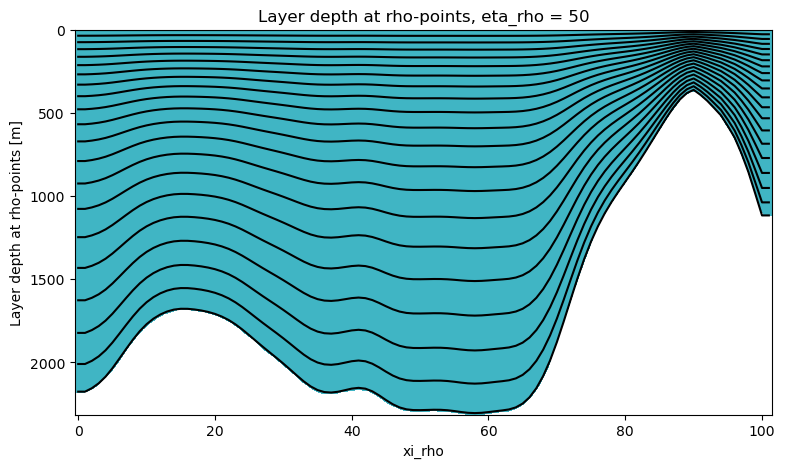

In [34]:
grid_with_large_critical_depth.plot_vertical_coordinate("layer_depth_rho", eta=50)

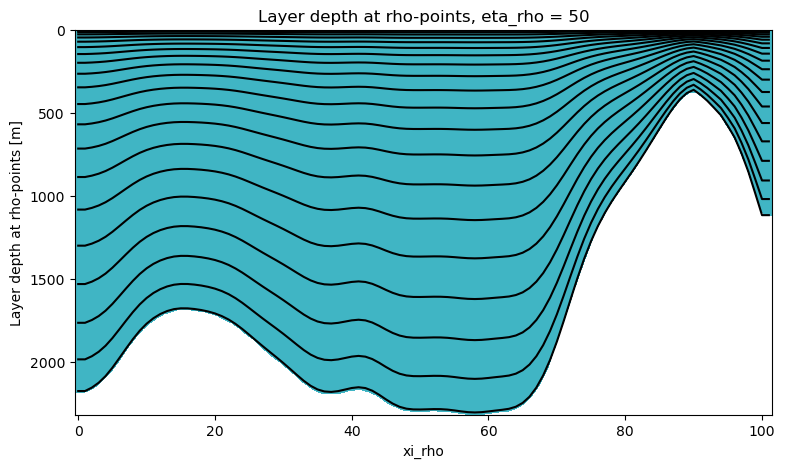

In [35]:
grid_with_small_critical_depth.plot_vertical_coordinate("layer_depth_rho", eta=50)

When comparing the three plots above, we observe that 

* increasing `hc` results in a higher proportion of the upper ocean having nearly evenly spaced levels. It's important to note that despite setting `hc` to 1000m in the second plot, the evenly spaced levels do not extend all the way down to 1000m. However, in deeper ocean regions (visible in the left part of the plot), we approach this depth threshold more closely.
* reducing `hc` leads to a smaller proportion of the upper ocean having nearly evenly spaced levels.

#### Surface and bottom control parameters

The surface control parameter `theta_s` and bottom control parameter `theta_b` determine how much the vertical grid is stretched near the surface and bottom, respectively. Let's change these two parameters and see what happens.

In [36]:
grid_with_large_theta_s = Grid(
    **fixed_grid_parameters,
    theta_s=10.0,
    theta_b=control_grid.theta_b,
    hc=control_grid.hc
)

grid_with_small_theta_s = Grid(
    **fixed_grid_parameters,
    theta_s=2.0,
    theta_b=control_grid.theta_b,
    hc=control_grid.hc
)

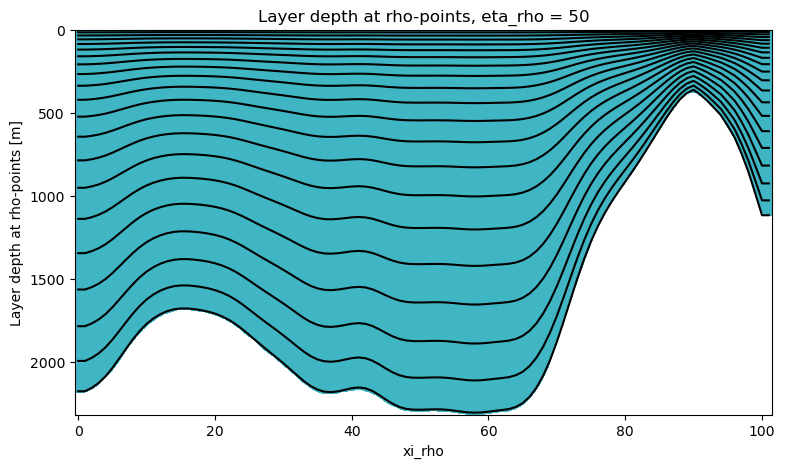

In [37]:
control_grid.plot_vertical_coordinate("layer_depth_rho", eta=50)

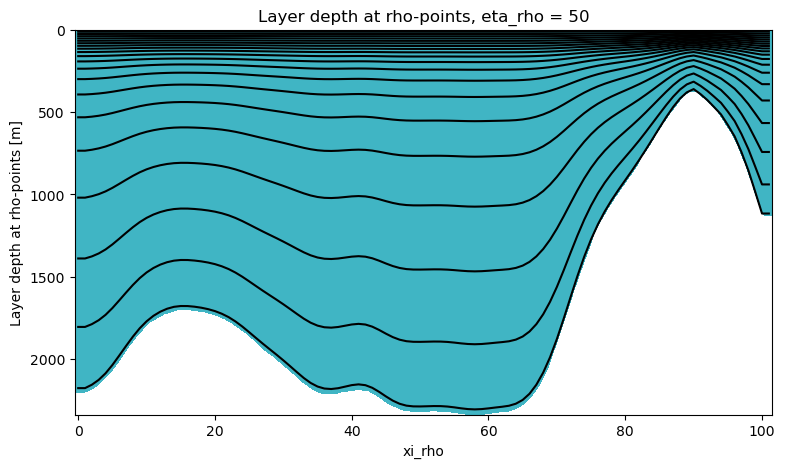

In [38]:
grid_with_large_theta_s.plot_vertical_coordinate("layer_depth_rho", eta=50)

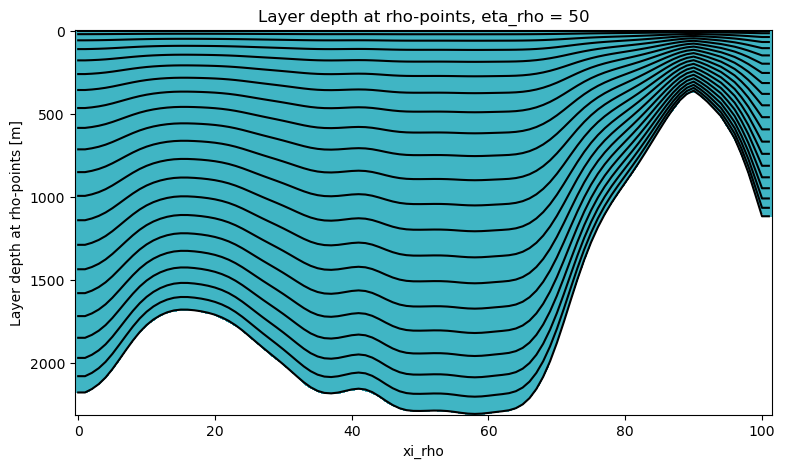

In [39]:
grid_with_small_theta_s.plot_vertical_coordinate("layer_depth_rho", eta=50)

When comparing the three plots above, we can see that 

* increasing `theta_s` leads to a refinement of the vertical grid near the surface,
* reducing `theta_s` leads to coarsening of the vertical grid near the surface.

We can play a similar game with the bottom control parameter `theta_b`.

In [40]:
grid_with_large_theta_b = Grid(
    **fixed_grid_parameters,
    theta_s=control_grid.theta_s,
    theta_b=4.0,
    hc=control_grid.hc
)

grid_with_small_theta_b = Grid(
    **fixed_grid_parameters,
    theta_s=control_grid.theta_s,
    theta_b=0.5,
    hc=control_grid.hc
)

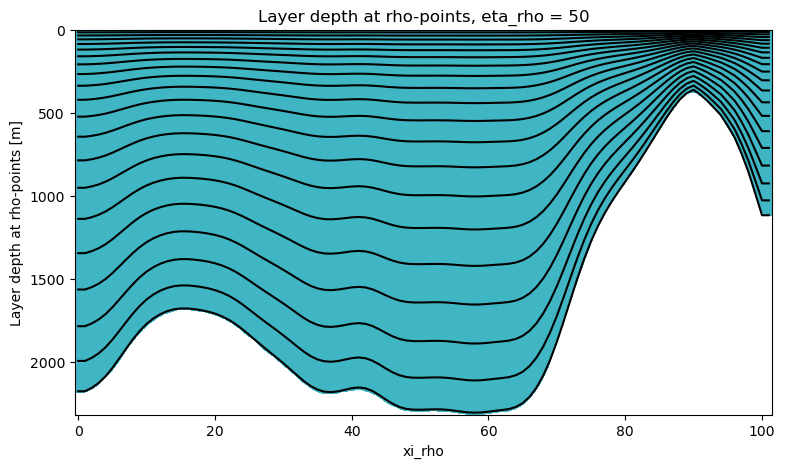

In [41]:
control_grid.plot_vertical_coordinate("layer_depth_rho", eta=50)

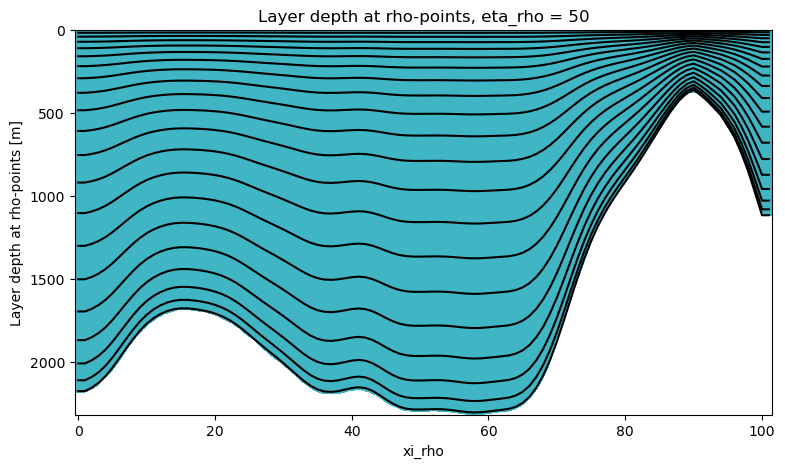

In [42]:
grid_with_large_theta_b.plot_vertical_coordinate("layer_depth_rho", eta=50)

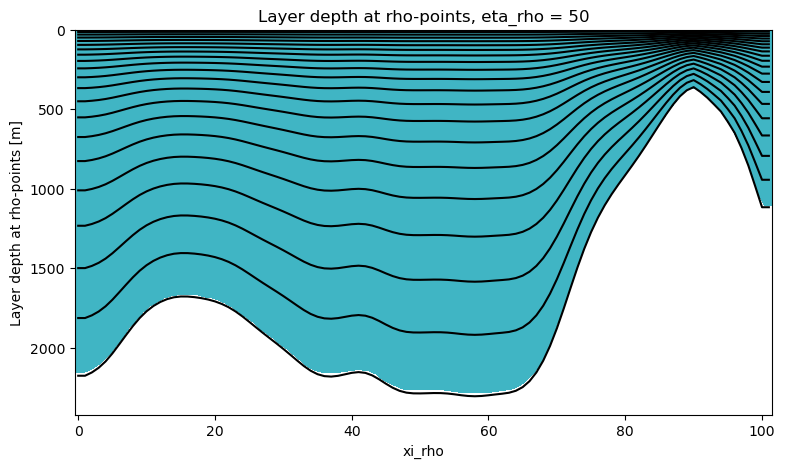

In [43]:
grid_with_small_theta_b.plot_vertical_coordinate("layer_depth_rho", eta=50)

Again, comparing the three plots above, we can see that 

* increasing `theta_b` leads to a refinement of the vertical grid near the bottom,
* reducing `theta_b` leads to coarsening of the vertical grid near the bottom.